In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyccl
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import *
from one_map import *

In [435]:
from matplotlib import rcParams
rcParams['xtick.direction'] = 'in'
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.visible'] = True
rcParams['ytick.major.size'] = 10
rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 12

---

## $S_8$ vs. galaxy bias 

* how do i make this connection?

In [53]:
# galaxy biases for clustering maps
biases = [1.42, 1.65, 1.60, 1.92, 2.00]

b1_array = np.linspace(1.22,1.62,21)
thr_ct = 10
array_len = thr_ct*3
nside = 256
N = 12*nside*nside
smoothing = 20
itr = 100
b=10

In [60]:
def galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b):
    
    N = 12*nside*nside
    
    # fixed map iterations
    v_all_fixed = np.zeros((itr,array_len))
    for i in range(itr):
        c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all_fixed[i] = np.concatenate((v0,v1,v2))
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
            v_all_mean[i] = np.mean(v_all_fixed[:,i])
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # applying 10 S_8 values
    v_all = np.zeros((b,array_len))
    for i in range(b):
        c_map, l_map = simulate_des_maps_bias(omega_m[i], sigma_8[i], smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all[i] = np.concatenate((v0,v1,v2))  

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    return L

In [110]:
L = np.zeros((len(b1_array),b))

for i,b1 in enumerate(b1_array):
    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
    
print(L.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
(21, 10)


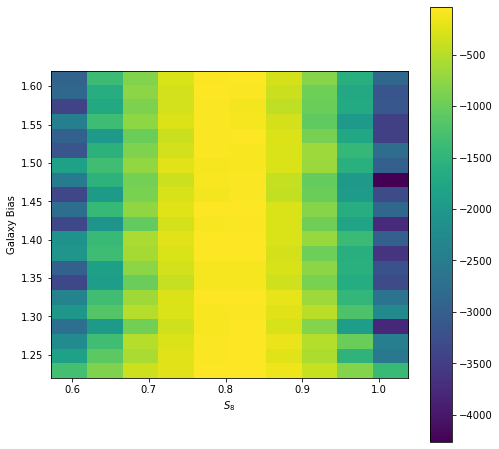

In [52]:
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
a = ax1.imshow(L, origin='lower', extent=[min(S_8),max(S_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

In [48]:
L = np.loadtxt('S8_GB_likelihood.out')

In [82]:
# wider galaxy bias range
'''
b1_array = np.linspace(0.92,1.82,10)
L = np.zeros((len(b1_array),thr_ct))
for i,b1 in enumerate(b1_array):
    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
'''

'\nb1_array = np.linspace(0.92,1.82,10)\nL = np.zeros((len(b1_array),thr_ct))\nfor i,b1 in enumerate(b1_array):\n    L[i] = galaxy_bias(b1,itr,thr_ct,nside,smoothing,array_len,b)\n    print(i)\n'

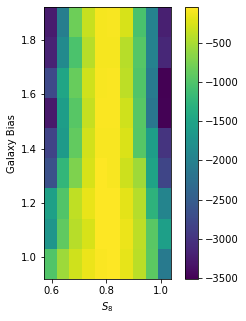

In [76]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
a = ax1.imshow(L_wide, origin='lower', extent=[min(S_8),max(S_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

In [196]:
# test sigma_8 vs bias

def galaxy_bias2(b1,itr,thr_ct,nside,smoothing,array_len,b):
    
    N = 12*nside*nside
    
    # fixed map iterations
    v_all_fixed = np.zeros((itr,array_len))
    for i in range(itr):
        c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all_fixed[i] = np.concatenate((v0,v1,v2))
        
    # fixed map mean    
    v_all_mean = np.zeros(array_len)
    for i in range(array_len):
            v_all_mean[i] = np.mean(v_all_fixed[:,i])
            
    # calculate S_8  
    omega_m = np.linspace(0.2,0.4,b)
    sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 
    
    # applying 10 S_8 values
    v_all = np.zeros((b,array_len))
    for i in range(b):
        c_map, l_map = simulate_des_maps_bias(0.3, sigma_8[i], smoothing, nside, b1, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        v_all[i] = np.concatenate((v0,v1,v2))  

    # covariance
    cov = np.cov((v_all_fixed.transpose()))
    
    # singular covariance matrix workaround
    good = cov.diagonal() > 0
    cov2 = cov[good][:, good]

    # calculate the likelihood          
    L = np.zeros(b)
    N_ = itr-1           # number of realisations - 1
    p = array_len        # number of data points

    try:
        inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
        for i in range(b):
            L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
    except:
        inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
        for i in range(b):
            d = (v_all[i] - v_all_mean)[good]
            L[i] = -0.5 * d @ inv_cov2 @ d
            
    return L

In [202]:
# NISHA RUN THIS TONIGHT

b1_array2 = np.linspace(1.22,1.62,5)

L2 = np.zeros((len(b1_array2),b))

for i,b1 in enumerate(b1_array2):
    L2[i] = galaxy_bias2(b1,itr,thr_ct,nside,smoothing,array_len,b)
    print(i)
    
print(L2.shape)

0
1
2
3
4
(5, 10)


In [201]:
np.linspace(1.22,1.62,5)

array([1.22, 1.32, 1.42, 1.52, 1.62])

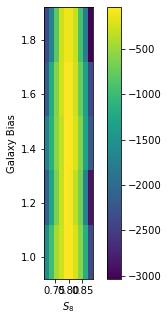

In [210]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
a = ax1.imshow(L2, origin='lower', extent=[min(sigma_8),max(sigma_8),min(b1_array),max(b1_array)])
a
ax1.set_aspect(2)
#ax1.set_title('Likelihood Plot')
ax1.set_xlabel('$S_8$')
ax1.set_ylabel('Galaxy Bias')
ax1.set(adjustable='box', aspect='equal')
fig.colorbar(a);
plt.savefig('s8_gb_L')

#### Plot MFs with varying galaxy biases around 1.42

In [227]:
bias_array = np.linspace(1.22,1.62,5)
thr_ct = 10
N = 12*nside*nside

v_b = np.zeros((len(bias_array),10))
v0_b = np.zeros((len(bias_array),10))
v1_b = np.zeros((len(bias_array),10))
v2_b = np.zeros((len(bias_array),10))

for i,b1 in enumerate(bias_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, 20, 256, b1, nmax=1)
    v_b[i],v0_b[i],v1_b[i],v2_b[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    print(i)

0
1
2
3
4


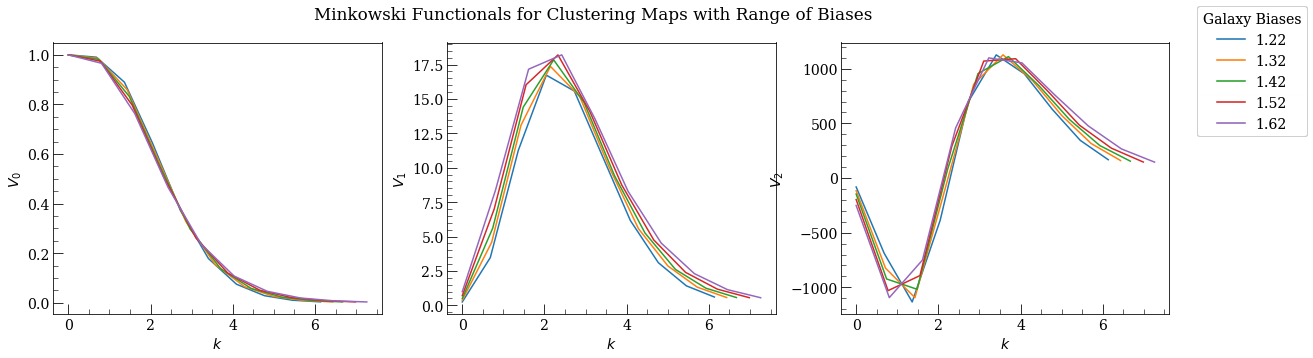

In [230]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Biases'))
for i in range(len(bias_array)):
    ax1.plot(v_b[i],v0_b[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_b[i],v1_b[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_b[i],v2_b[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(1.22,1.62,5),title = 'Galaxy Biases') 

In [232]:
# look at smoothing clustering for comparison
s_array = np.linspace(10,60,6)
thr_ct = 10
nside = 256
N = 12*nside*nside

v_s = np.zeros((len(s_array),10))
v0_s = np.zeros((len(s_array),10))
v1_s = np.zeros((len(s_array),10))
v2_s = np.zeros((len(s_array),10))

for i,s in enumerate(s_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, s, 256, b1, nmax=1)
    v_s[i],v0_s[i],v1_s[i],v2_s[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)

0
1
2
3
4
5


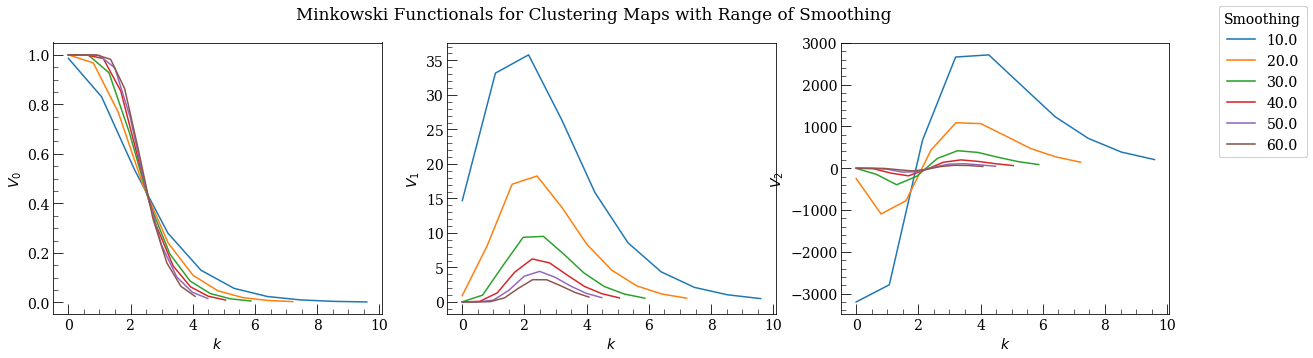

In [236]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Smoothing'))
for i in range(len(s_array)):
    ax1.plot(v_s[i],v0_s[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_s[i],v1_s[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_s[i],v2_s[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(10,60,6),title = 'Smoothing') 

In [245]:
# smoothing lensing
s_array = np.linspace(10,60,6)
thr_ct = 10
nside = 256
N = 12*nside*nside

v_s = np.zeros((len(s_array),10))
v0_s = np.zeros((len(s_array),10))
v1_s = np.zeros((len(s_array),10))
v2_s = np.zeros((len(s_array),10))

for i,s in enumerate(s_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, s, 256, b1, nmax=1)
    v_s[i],v0_s[i],v1_s[i],v2_s[i] = calc_mf(l_map[0], thr_ct, N, is_clustering=False)

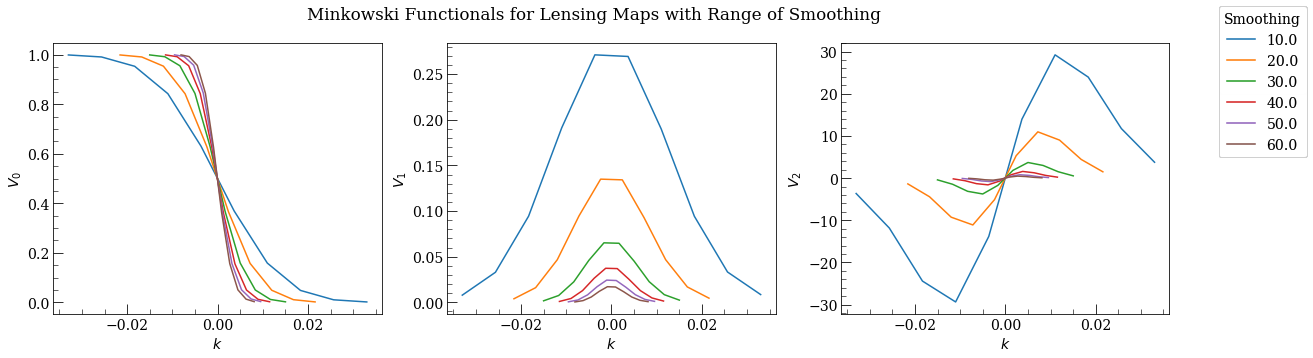

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Range of Smoothing'))
for i in range(len(s_array)):
    ax1.plot(v_s[i],v0_s[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_s[i],v1_s[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_s[i],v2_s[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(np.linspace(10,60,6),title = 'Smoothing') 

In [234]:
# look at nside for comparison
n_array = [256,512,1024]
thr_ct = 10
smoothing = 20
N = 12*nside*nside

v_n = np.zeros((len(n_array),10))
v0_n = np.zeros((len(n_array),10))
v1_n = np.zeros((len(n_array),10))
v2_n = np.zeros((len(n_array),10))

for i,n in enumerate(n_array):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, n, b1, nmax=1)
    v_n[i],v0_n[i],v1_n[i],v2_n[i] = calc_mf(c_map[0], thr_ct, N, is_clustering=True)

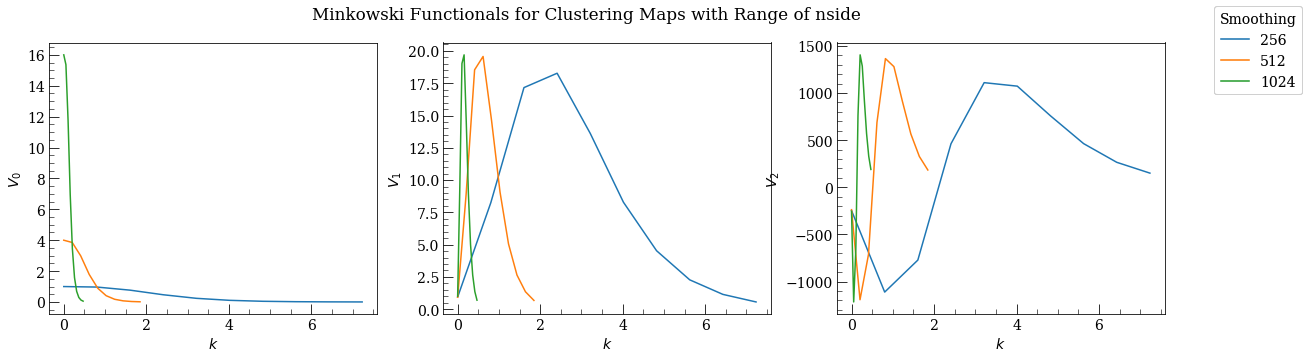

In [239]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of nside \n'))
for i in range(len(n_array)):
    ax1.plot(v_n[i],v0_n[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_n[i],v1_n[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_n[i],v2_n[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend(n_array,title = 'Smoothing') 

In [277]:
# look at threshold for comparison
t_array = np.linspace(10,20,6)
thr_ct = 10
smoothing = 20
nside = 256
N = 12*nside*nside

# 10
v_t_10 = np.zeros(10)
v0_t_10 = np.zeros(10)
v1_t_10 = np.zeros(10)
v2_t_10 = np.zeros(10)

# 12
v_t_12 = np.zeros(12)
v0_t_12 = np.zeros(12)
v1_t_12 = np.zeros(12)
v2_t_12 = np.zeros(12)

#14
v_t_14 = np.zeros(14)
v0_t_14 = np.zeros(14)
v1_t_14 = np.zeros(14)
v2_t_14 = np.zeros(14)

#16
v_t_16 = np.zeros(16)
v0_t_16 = np.zeros(16)
v1_t_16 = np.zeros(16)
v2_t_16 = np.zeros(16)

#18
v_t_18 = np.zeros(18)
v0_t_18 = np.zeros(18)
v1_t_18 = np.zeros(18)
v2_t_18 = np.zeros(18)

#20
v_t_20 = np.zeros(20)
v0_t_20 = np.zeros(20)
v1_t_20 = np.zeros(20)
v2_t_20 = np.zeros(20)

# build simulation
c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, n, b1, nmax=1)

# calc mfs for different threshold values
v_t_10,v0_t_10,v1_t_10,v2_t_10 = calc_mf(c_map[0], 10, N, is_clustering=True)
v_t_12,v0_t_12,v1_t_12,v2_t_12 = calc_mf(c_map[0], 12, N, is_clustering=True)
v_t_14,v0_t_14,v1_t_14,v2_t_14 = calc_mf(c_map[0], 14, N, is_clustering=True)
v_t_16,v0_t_16,v1_t_16,v2_t_16 = calc_mf(c_map[0], 16, N, is_clustering=True)
v_t_18,v0_t_18,v1_t_18,v2_t_18 = calc_mf(c_map[0], 18, N, is_clustering=True)
v_t_20,v0_t_20,v1_t_20,v2_t_20 = calc_mf(c_map[0], 20, N, is_clustering=True)

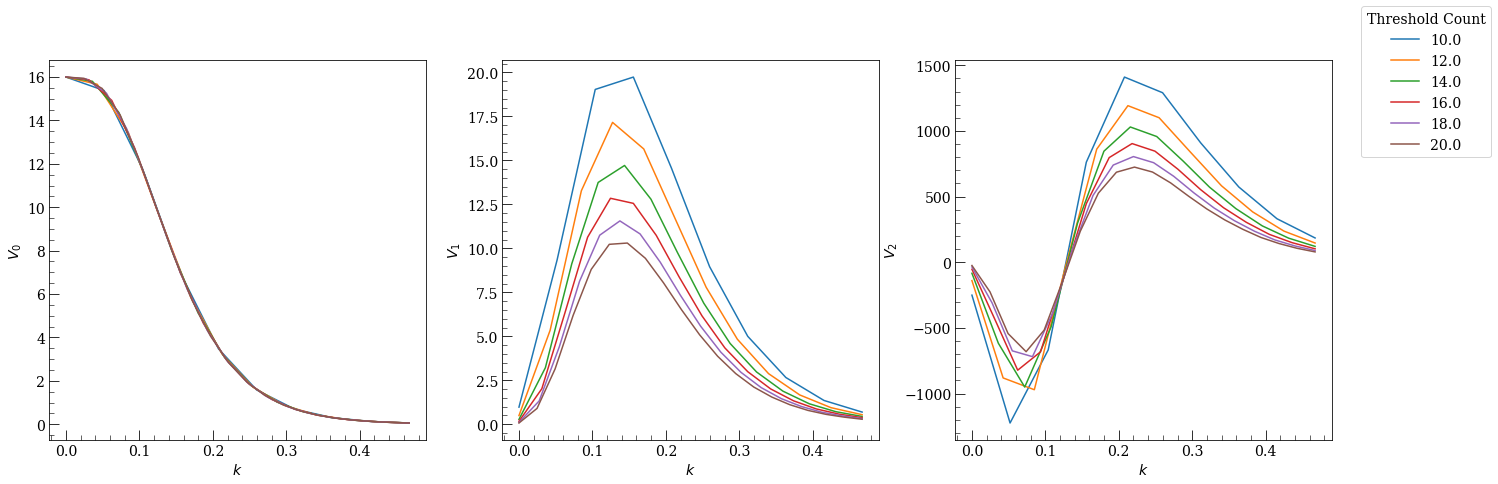

In [286]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23,7))
#fig.suptitle(('Minkowski Functionals for Clustering Maps with Range of Threshold \n'))

ax1.plot(v_t_10,v0_t_10,label='10')
ax1.plot(v_t_12,v0_t_12,label='12')
ax1.plot(v_t_14,v0_t_14,label='14')
ax1.plot(v_t_16,v0_t_16,label='16')
ax1.plot(v_t_18,v0_t_18,label='18')
ax1.plot(v_t_20,v0_t_20,label='20')
ax1.set_xlabel('$k$')
ax1.set_ylabel('$V_0$')

ax2.plot(v_t_10,v1_t_10,label='10')
ax2.plot(v_t_12,v1_t_12,label='12')
ax2.plot(v_t_14,v1_t_14,label='14')
ax2.plot(v_t_16,v1_t_16,label='16')
ax2.plot(v_t_18,v1_t_18,label='18')
ax2.plot(v_t_20,v1_t_20,label='20')
ax2.set_xlabel('$k$')
ax2.set_ylabel('$V_1$')

ax3.plot(v_t_10,v2_t_10,label='10')
ax3.plot(v_t_12,v2_t_12,label='12')
ax3.plot(v_t_14,v2_t_14,label='14')
ax3.plot(v_t_16,v2_t_16,label='16')
ax3.plot(v_t_18,v2_t_18,label='18')
ax3.plot(v_t_20,v2_t_20,label='20')
ax3.set_xlabel('$k$')
ax3.set_ylabel('$V_2$')

fig.legend(t_array,title = 'Threshold Count'); 

### Individual Steps

In [23]:
v_all_fixed = np.zeros((itr,array_len))
for i in range(itr):
    c_map, l_map = simulate_des_maps_bias(0.3, 0.8, smoothing, nside, b1, nmax=1)
    v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    v_all_fixed[i] = np.concatenate((v0,v1,v2))
    print(i)

In [28]:
v_all_mean = np.zeros(array_len)
for i in range(array_len):
    v_all_mean[i] = np.mean(v_all_fixed[:,i])

In [29]:
# calculate S_8

omega_m = np.linspace(0.2,0.4,b)
sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527
    
# calculate S_8
S_8 = sigma_8 * (omega_m/0.3)**0.5329788249790618 

In [30]:
# applying 10 S_8 values

v_all = np.zeros((b,array_len))
for i in range(b):
    c_map, l_map = simulate_des_maps_bias(omega_m[i], sigma_8[i], smoothing, nside, b1, nmax=1)
    v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
    v_all[i] = np.concatenate((v0,v1,v2))

In [31]:
cov = np.cov((v_all_fixed.transpose()))

In [33]:
# singular covariance matrix workaround
good = cov.diagonal() > 0
cov2 = cov[good][:, good]

# calculate the likelihood          
L = np.zeros(b)
N_ = itr-1           # number of realisations - 1
p = array_len        # number of data points
    
try:
    inv_cov = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov)
    for i in range(b):
        L[i] = -0.5 * (v_all[i] - v_all_mean) @ inv_cov @ (v_all[i] - v_all_mean)
except:
    inv_cov2 = ((N_)/(N_ - p - 1)) * np.linalg.inv(cov2)
    for i in range(b):
        d = (v_all[i] - v_all_mean)[good]
        L[i] = -0.5 * d @ inv_cov2 @ d

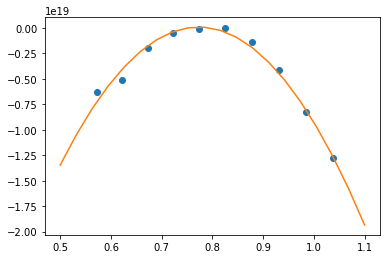

In [35]:
coefficient = np.polyfit(S_8,L,2)
poly = np.poly1d(coefficient)     
new_x = np.linspace(0.5,1.1,20)
new_y = poly(new_x)
plt.plot(S_8, L, "o", new_x, new_y);

In [ ]:
# calculate likelihood (S_8,b_1) 
# first for clustering map

---

## Predicting MFs using an interpolator to save time

* should all threshold values, 30 total
* do clustering and lensing maps separately

In [292]:
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

# make a grid of omega sigma points
a=4
omega,sigma = np.mgrid[0.2:0.4:a*1j,0.7:0.9:a*1j]

smoothing = 5
nside = 256

In [376]:
# calculate MFs for the grid -> put output in a new grid

# clustering map
V_clust = np.zeros((a,a,thr_ct*3))
os_grid = np.vstack((omega[:,0],sigma[0]))

for i,o in enumerate(omega[:,0]):
    for j,s in enumerate(sigma[0]):
        c_map, l_map = simulate_des_maps(o, s, smoothing, nside, nmax=1)
        v,v0,v1,v2 = calc_mf(c_map[0], thr_ct, N, is_clustering=True)
        V_clust[i][j] = np.concatenate((v0,v1,v2))

In [337]:
# build interpolator
rgi = RegularGridInterpolator(os_grid, V_clust)#[:,:,0])#, method='linear', bounds_error=True, fill_value=nan)

In [367]:
# test model on data used to build model

V_test = np.zeros((a,a,thr_ct*3))
for i in range(a):
    for j in range(a):
        V_test[i][j] = rgi((os_grid[0][i],os_grid[1][j]))#rgi(os_grid[:,i])#

V_test.shape

(4, 4, 30)

In [377]:
for i,o in enumerate(omega[:,0]):
    for j,s in enumerate(sigma[0]):
        V_test[i][j] = rgi((o,s))
        
V_test.shape

(4, 4, 30)

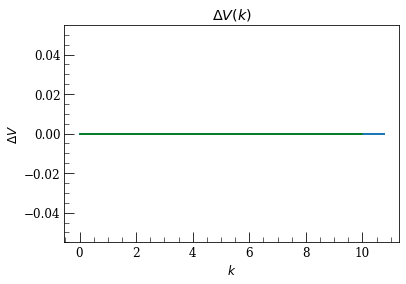

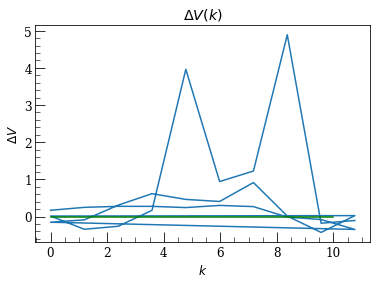

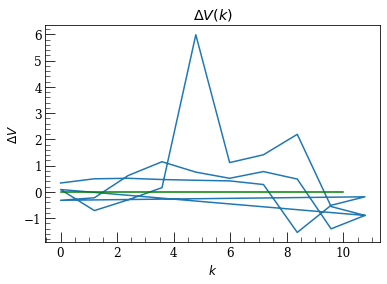

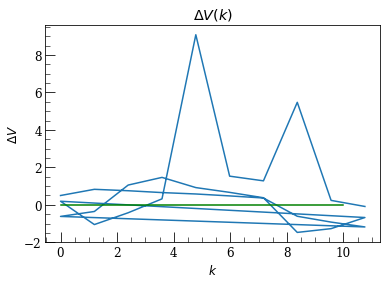

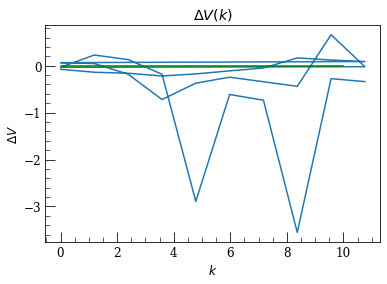

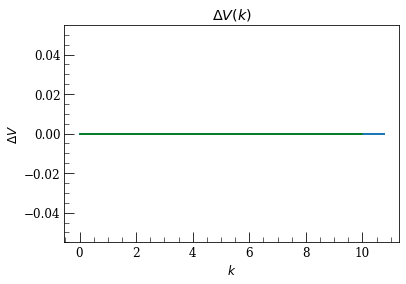

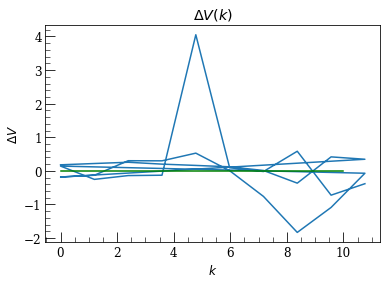

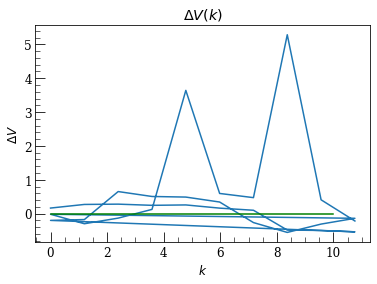

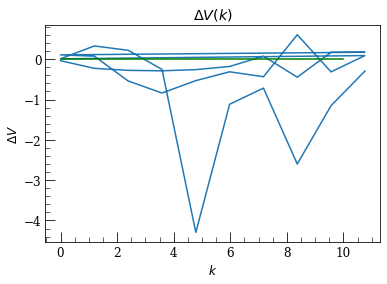

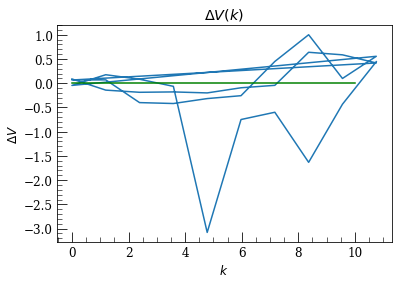

<Figure size 432x288 with 0 Axes>

In [438]:
x = np.linspace(0,10,10)
y = np.zeros(len(x))
V = np.concatenate((v,v,v))

delta_V = (V_clust_d - V_test)/np.std(V_clust_d,axis=0)
delta_V_plot = delta_V.reshape(16,30)

for t in range(10):
    plt.title((f'$\Delta V(k)$'))
    plt.plot(V,delta_V_plot[:][t])
    plt.plot(x,y,color='green')
    plt.xlabel('$k$')
    plt.ylabel('$\Delta V$')
    plt.figure();

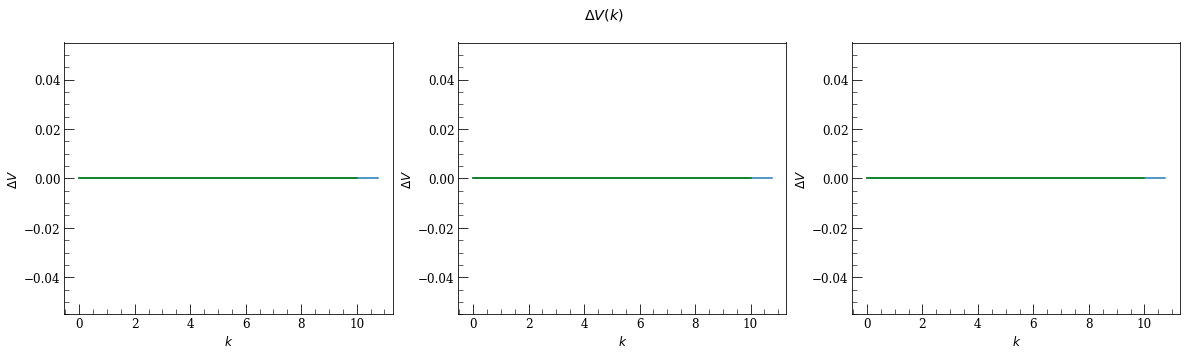

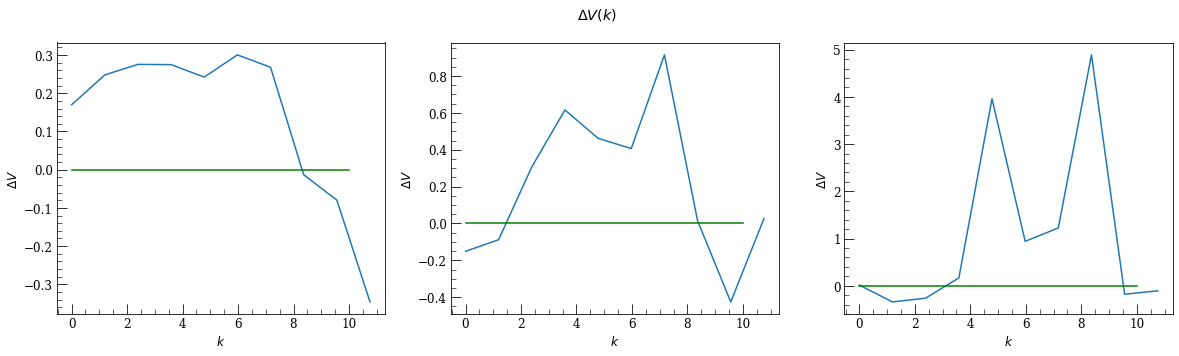

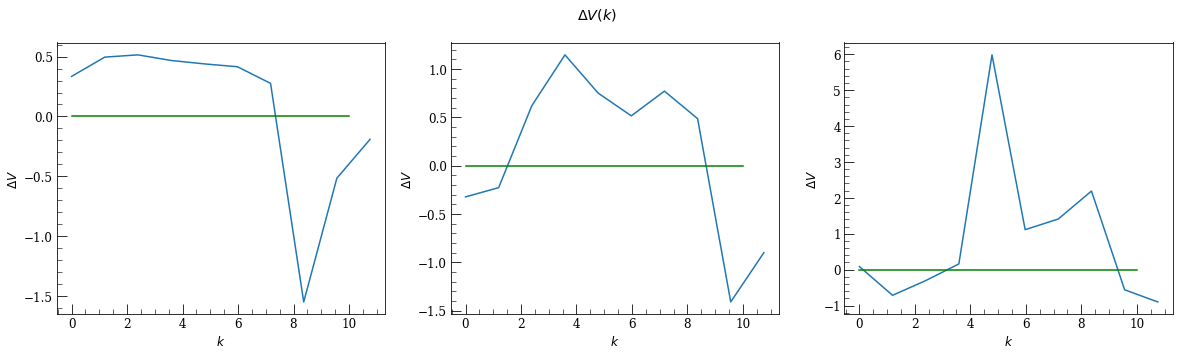

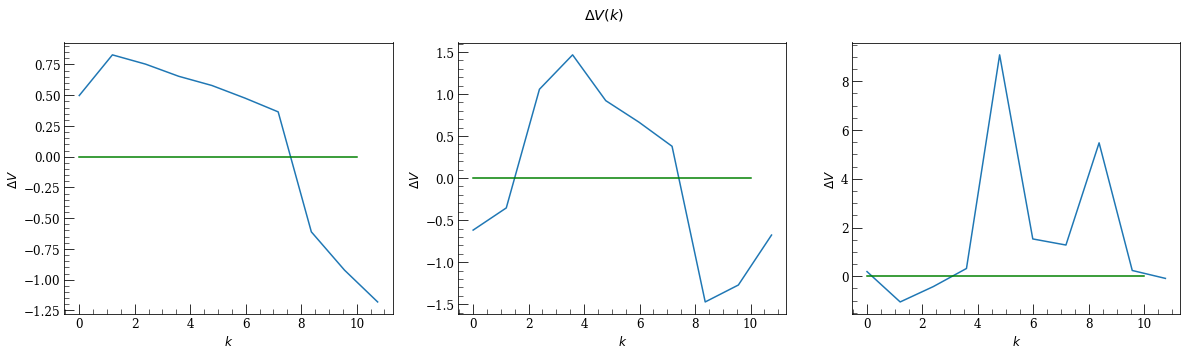

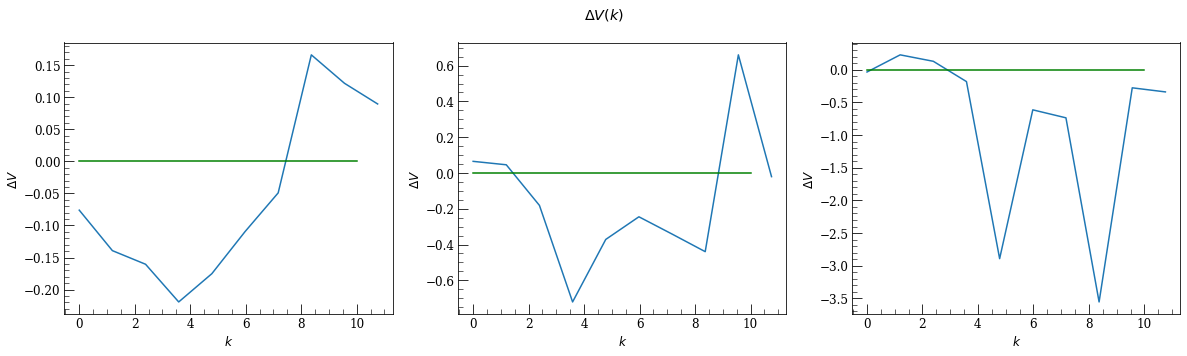

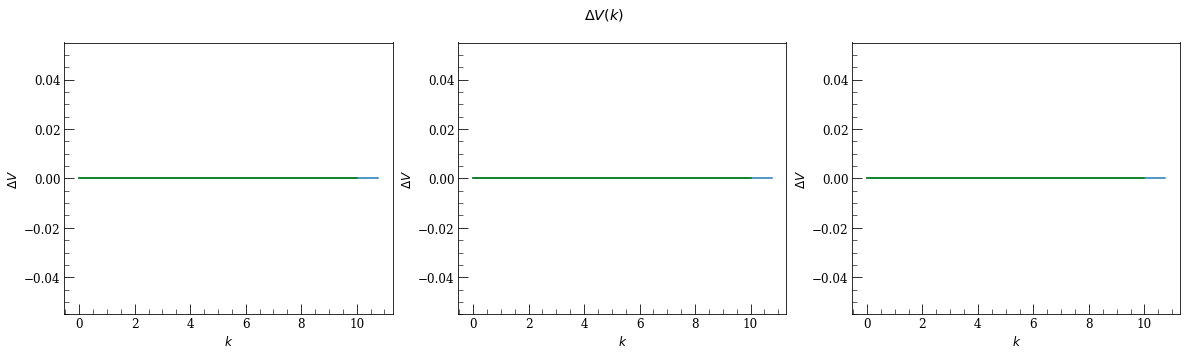

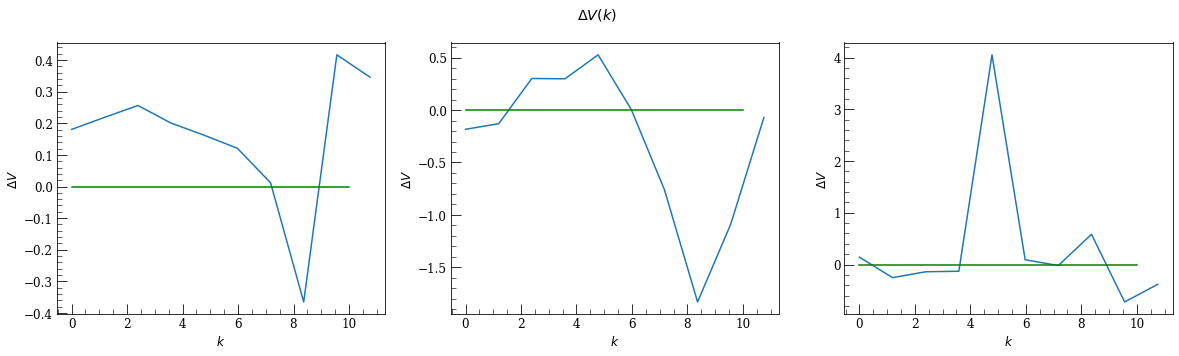

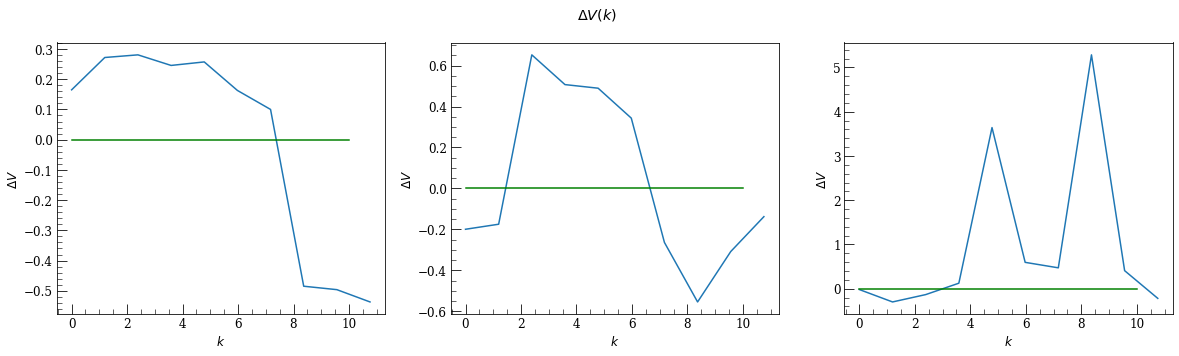

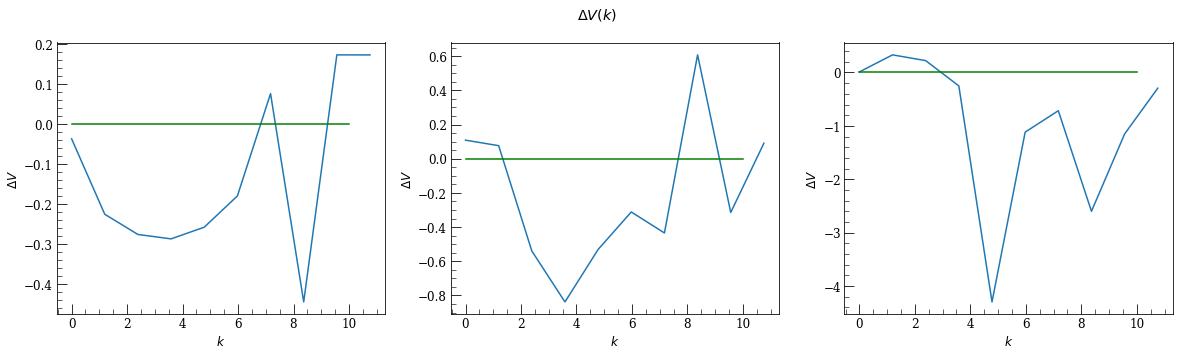

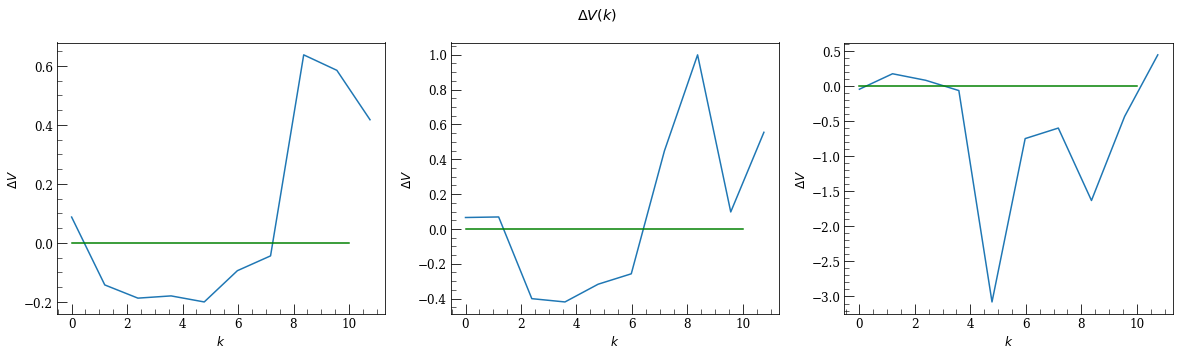

In [439]:
# compare real data to model test output data -> error plot

x = np.linspace(0,10,10)
y = np.zeros(len(x))

delta_V = (V_clust_d - V_test)/np.std(V_clust_d,axis=0)

delta_V0_plot = delta_V[:,:,0:10].reshape(16,10)
delta_V1_plot = delta_V[:,:,10:20].reshape(16,10)
delta_V2_plot = delta_V[:,:,20:30].reshape(16,10)

for t in range(0,10):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
    fig.suptitle((f'$\Delta V(k)$'))
    ax1.plot(v,delta_V0_plot[:][t])
    ax1.plot(x,y,color='green')
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$\Delta V$')
    ax2.plot(v,delta_V1_plot[:][t])
    ax2.plot(x,y,color='green')
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$\Delta V$')
    ax3.plot(v,delta_V2_plot[:][t])
    ax3.plot(x,y,color='green')
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$\Delta V$')


In [478]:
# make a grid of in between grid points  - can't exceed current points?

test = np.copy(os_grid)
for i in range(2):
    for j in range(4):
        if j<3:
            test[i][j] = test[i][j] + np.random.random(1)*.001
        else:
            test[i][j] = test[i][j] - np.random.random(1)*.001
print(test)

[[0.20021412 0.26688448 0.33428267 0.39954557]
 [0.70035431 0.76669572 0.8340773  0.89931406]]


In [479]:
# apply model to test points
V_test = np.zeros((a,thr_ct*3))
for i in range(a):
    V_test[i] = rgi(test[:,i])

V_test.shape

(4, 30)

In [480]:
V_test

array([[ 9.75101114e-01,  8.23368069e-01,  5.48546975e-01,
         2.94373675e-01,  1.34654420e-01,  5.52932356e-02,
         2.10624489e-02,  7.63409428e-03,  2.80625207e-03,
         9.63749778e-04,  1.82369189e+01,  3.64932987e+01,
         3.97584076e+01,  3.03013443e+01,  1.83381128e+01,
         9.52411649e+00,  4.49136424e+00,  1.97065759e+00,
         8.41599799e-01,  3.59491046e-01, -4.17688518e+03,
        -3.55665540e+03,  4.69654928e+02,  3.19262392e+03,
         3.46156834e+03,  2.50542108e+03,  1.49385848e+03,
         7.67883176e+02,  3.66738215e+02,  1.75384162e+02],
       [ 9.72443256e-01,  8.05063473e-01,  5.21565531e-01,
         2.73699236e-01,  1.24179280e-01,  5.17724984e-02,
         2.03321413e-02,  7.81596970e-03,  3.02460806e-03,
         1.12132629e-03,  2.05625854e+01,  3.90868036e+01,
         4.06606220e+01,  2.98299953e+01,  1.75676896e+01,
         9.13481873e+00,  4.43301361e+00,  1.99693923e+00,
         8.67972802e-01,  4.07014953e-01, -4.48039286e+